In this notebook, we develop new models that have the same structure as the previous models. We adapt them to be able to train on more data (including the mobility and the number of infected)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats
import sys
sys.path.append('./models/')
from SIRD import *
from exponential_regression import *
from Arima import *


In [5]:
# importing mobility from the csv file
df_mobility=pd.read_csv('mobility.csv')
df_mobility.drop(columns=['Unnamed: 0'], inplace=True)
mobility=np.array(df_mobility['mobility'])

df = pd.read_csv('deaths_and_infections.csv')

# remove a columns from a df: 
df.drop(columns=['Unnamed: 0'], inplace=True)
new_deaths=np.array(df['new_deaths'])
n_infected=np.array(df['n_infected'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))
mob_shifted=np.concatenate((np.array([ 0 for i in range(17)]), mobility))
mob_17_days_ahead=(np.array([mob_shifted[i-17] for i in range(17, len(mob_shifted))]))

In [6]:
split = 35
reach=7
deaths_train=new_deaths[:split]
infected_train=n_infected[:split]
mob_train=mob_17_days_ahead[:split]
data_train=np.array([deaths_train, infected_train, mob_train])
dates_of_pandemic_train=dates_of_pandemic[:split]

In [7]:
data =np.array([ new_deaths, n_infected, mob_17_days_ahead ])

Multi dimensional exponential regression : 

In [8]:
myexp=ExponentialRegression()
myexp.train(dates_of_pandemic_train, data_train[0])

In [9]:
myexp_multi=MultiDimensionalExponentialRegression()
myexp_multi.train(dates_of_pandemic_train, data_train)

c:\Users\grego\Miniconda3\envs\env_qcm\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\grego\Documents\code\covid_internship\./models\exponential_regression.py:201: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * mobility + c * i+ d * n_infected) +e


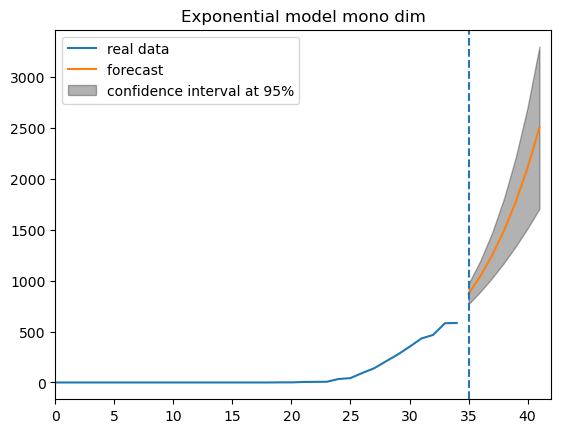

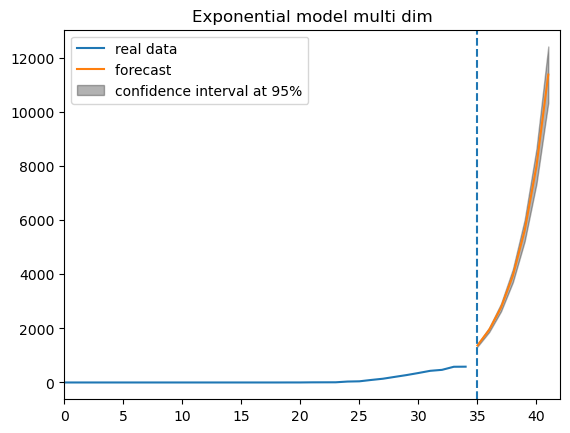

In [10]:
myexp.plot(7, 0.05, title='Exponential model mono dim')
myexp_multi.plot(7, 0.05, title='Exponential model multi dim')

Multi dimensional SIRD

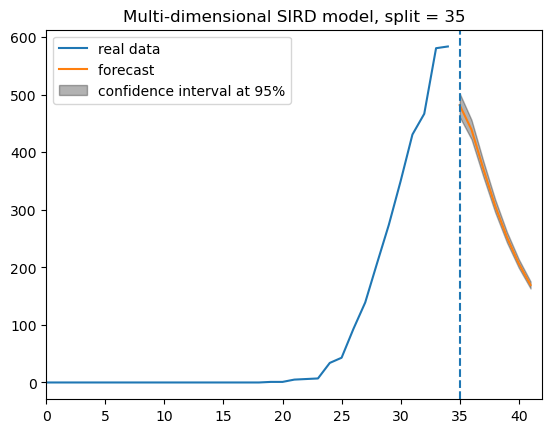

In [15]:

sird_multi=Multi_SIRD_model()
sird_multi.choose_model(True, True, True)
sird_multi.train(dates_of_pandemic_train, data_train)
sird_multi.plot(7, 0.05, title='Multi-dimensional SIRD model, split = '+ str(split))


VAR: 

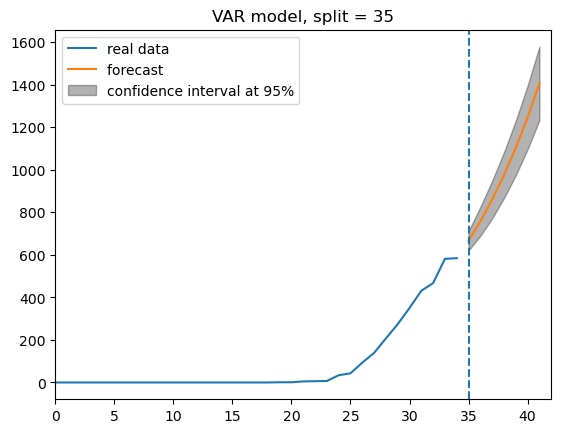

In [18]:
myvar=VAR_m()
myvar.train(dates_of_pandemic_train, data_train)
myvar.plot(7, 0.05, title='VAR model, split = '+ str(split))